In [12]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from os import path
from tec_reduced_model.set_parameters import (
    set_thermal_parameters,
    set_experiment_parameters,
    set_ambient_temperature,
)
from tec_reduced_model.process_experimental_data import import_thermal_data, get_idxs
from __future__ import print_function
import dfols
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

plt.style.use(['science','vibrant'])

plt.rcParams.update({
    "font.family": "sans-serif",
    "text.usetex": False,
    "font.size": 8,
    "axes.labelsize": 10,
})

In [23]:
# Change simulation parameters here
temperature = 25  # in degC, valid values: 0, 10, 25
Crate = 1         # valid values: 0.5, 1, 2
cells_ignore = ["792","789","791"]    # cells to ignore, in this case we ignore cell 791 because the data for that cell is faulty

In [24]:
# Define the TSPMe model
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

dataset = import_thermal_data(Crate, temperature)
data_conc = {"time": [], "voltage": [], "temperature": []}

for cell, data in dataset.items():
    if cell in cells_ignore:
        continue

    idx_start, idx_end = get_idxs(data, Crate * 5, 5 / 3)
    if len(idx_end) == 1:
        idx_end = np.append(idx_end, len(data["Time [s]"]))

    data_conc["time"] = np.append(
        data_conc["time"],
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
    )
    data_conc["voltage"] = np.append(
        data_conc["voltage"], data["Voltage [V]"][idx_start[0] : idx_end[1]]
    )
    data_conc["temperature"] = np.append(
        data_conc["temperature"],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
    )

In [25]:
def R_squared(solution, x_data, y_data):
    y_bar = np.mean(y_data)
    SS_tot = np.sum((y_data - y_bar) ** 2)
    res = y_data - solution(x_data)
    res = res[~np.isnan(res)]  # remove NaNs due to extrapolation
    SS_res = np.sum(res ** 2)
    n=len(y_data)

    return 1 - SS_res / n

In [26]:
def j0_neg(c_e, c_s_surf, T):
    """
    This function has been copied from the Chen2020 parameter set:
    pybamm/input/parameters/lithium_ion/negative_electrodes/graphite_Chen2020
    /graphite_LGM50_electrolyte_exchange_current_density_Chen2020.py

    Similar could be done for the positive exchange current density
    """

    # m_ref = 6.48e-7  # (A/m2)(mol/m3)**1.5 - includes ref concentrations

    m_ref = pybamm.Parameter("Negative electrode reaction coefficient")
    E_r = 35000
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    c_n_max = pybamm.Parameter("Maximum concentration in negative electrode [mol.m-3]")

    return (
        m_ref * arrhenius * c_e ** 0.5 * c_s_surf ** 0.5 * (c_n_max - c_s_surf) ** 0.5
    )

In [27]:
# Define parameter set Chen 2020 (see PyBaMM documentation for details)
# This is the reference parameter set, which we then update for the adjusted thermal parameters
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

# We now update the parameter set for the adjusted parameters
param = set_thermal_parameters(param, 16, 2.32e6, temperature)
param = set_experiment_parameters(param, Crate, temperature)
param = set_ambient_temperature(param, Crate, temperature)
    
    # Define the experiment to be a CC discharge at the defined C-rate followed by a 2-hour relaxation
experiment = pybamm.Experiment(
    [
        "Discharge at {}C until 2.5 V (5 seconds period)".format(Crate),
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

In [28]:

param.update({
    "Negative electrode exchange-current density [A.m-2]": j0_neg,
    "Negative electrode reaction coefficient": "[input]",
    "Negative electrode diffusivity [m2.s-1]" : "[input]",
}, check_already_exists=False)
    
    # Solve the model
simulation = pybamm.Simulation(
        model,
        parameter_values=param,
        experiment=experiment,
    )
    
def fitness(x):
    
    
    simulation.solve(inputs={"Negative electrode reaction coefficient": x[0,1],"Negative electrode diffusivity [m2.s-1]" : x[0,0]})
    solution = simulation.solution
    #R_squared(solution["X-averaged cell temperature [K]"], data_conc["time"], data_conc["temperature"])

    
    return np.array(1-R_squared(solution["X-averaged cell temperature [K]"], data_conc["time"], (data_conc["temperature"] + 273.15)))     #(np.abs(sol_sq-exp_sq))

In [29]:
# Create bounds
max_bound = np.array([ 2.06e-10, 2.18589831e-5])
min_bound = np.array([ 2.06e-16, 2.18589831e-9])
bounds = (min_bound, max_bound)
#x0 =np.array([5e-14,6.48e-7])

In [30]:
%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.6, 'w':0.8}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(fitness, iters=1000)

2022-03-04 14:39:32,473 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.8}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.609
2022-03-04 14:52:44,211 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6085507006371944, best pos: [1.8045803e-11 1.0954161e-06]


CPU times: total: 13min 11s
Wall time: 13min 11s


In [39]:
print(pos)
fitness(pos)

[1.8045803e-11 1.0954161e-06]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [31]:
# Define the TSPMe model
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

# Define parameter set Chen 2020 (see PyBaMM documentation for details)
# This is the reference parameter set, which we then update for the adjusted thermal parameters
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

# We now update the parameter set for the adjusted parameters
param = set_thermal_parameters(param, 16, 2.32e6, temperature)
param = set_experiment_parameters(param, Crate, temperature)
param = set_ambient_temperature(param, Crate, temperature)
param["Negative electrode diffusivity [m2.s-1]"] = pos[0]
param.update({
        "Negative electrode exchange-current density [A.m-2]": j0_neg,
        "Negative electrode reaction coefficient": "[input]",
    }, check_already_exists=False)

# Define the experiment to be a CC discharge at the defined C-rate followed by a 2-hour relaxation
experiment = pybamm.Experiment(
    [
        "Discharge at {}C until 2.5 V (5 seconds period)".format(Crate),
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

# Solve the model
simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)
simulation.solve( inputs={"Negative electrode reaction coefficient": pos[1]})
solution = simulation.solution


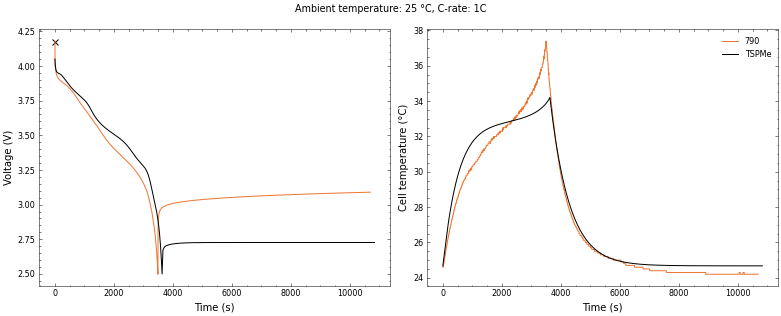

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
dataset = import_thermal_data(Crate, temperature)
data_conc = {"time": [], "voltage": [], "temperature": []}

for cell, data in dataset.items():
    if cell in cells_ignore:
        continue

    idx_start, idx_end = get_idxs(data, Crate * 5, 5 / 3)
    if len(idx_end) == 1:
        idx_end = np.append(idx_end, len(data["Time [s]"]))

    axes[0].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Voltage [V]"][idx_start[0] : idx_end[1]],
        label=cell,
    )
    axes[1].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
        label=cell,
    )

    data_conc["time"] = np.append(
        data_conc["time"],
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
    )
    data_conc["voltage"] = np.append(
        data_conc["voltage"], data["Voltage [V]"][idx_start[0] : idx_end[1]]
    )
    data_conc["temperature"] = np.append(
        data_conc["temperature"],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
    )

    
axes[0].plot(
    solution["Time [s]"].entries,
    solution["Terminal voltage [V]"].entries,
    color="black",
    label="TSPMe",
)

axes[0].scatter(
    0,
    solution["X-averaged battery open circuit voltage [V]"].entries[0],
    marker="x",
    color="black",
)

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Voltage (V)")

axes[1].plot(
    solution["Time [s]"].entries,
    solution["X-averaged cell temperature [K]"].entries - 273.15,
    color="black",
    label="TSPMe",
)

axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Cell temperature (°C)")
axes[1].legend()
    
fig.suptitle("Ambient temperature: {} °C, C-rate: {}C".format(temperature, Crate))    

fig.tight_layout()
fig.subplots_adjust(top=0.9)